In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter

from numba import njit
from scipy.signal import savgol_filter

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [3]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

In [4]:
base = '/n/home01/abeane/starbar/plots/bar_prop/data/'

bar_prop_N = h5.File(base + 'bar_prop_Nbody-lvl3.hdf5', mode='r')
bar_prop_S = h5.File(base + 'bar_prop_phantom-vacuum-Sg20-Rc3.5-lvl3.hdf5', mode='r')

In [5]:
def extract_pos_mass(sn, center):
    pos = np.array([]).reshape((0, 3))
    mass = np.array([])
    for i in [2, 3, 4]:
        if sn.NumPart_Total[i] == 0:
            continue

        part = getattr(sn, 'part'+str(i))

        pos_ = part.pos.value - center
        pos = np.concatenate((pos, pos_))

        if sn.MassTable[i] > 0.0:
            mass_ = np.full(sn.NumPart_Total[i], sn.MassTable[i])
        else:
            mass_ = part.mass.value
        
        mass = np.concatenate((mass, mass_))
    
    return pos, mass

In [6]:
sn = read_snap(500, 1, parttype=[2, 3, 4], fields=None)

In [7]:
center = np.array([200., 200., 200.])
pos, mass = extract_pos_mass(sn, center)
pos = rotate_pos(pos, -bar_prop_S['bar_angle'][500])

In [10]:
young_star_pos = sn.part4.pos.value - center
age = sn.Time.value - sn.part4.GFM_StellarFormationTime
young_star_pos = young_star_pos[age < 0.1]
young_star_pos = rotate_pos(young_star_pos, -bar_prop_S['bar_angle'][500])

young_star_mass = sn.part4.mass.value[age < 0.1]

4.629624097543004
0.05742103521712125
0.0


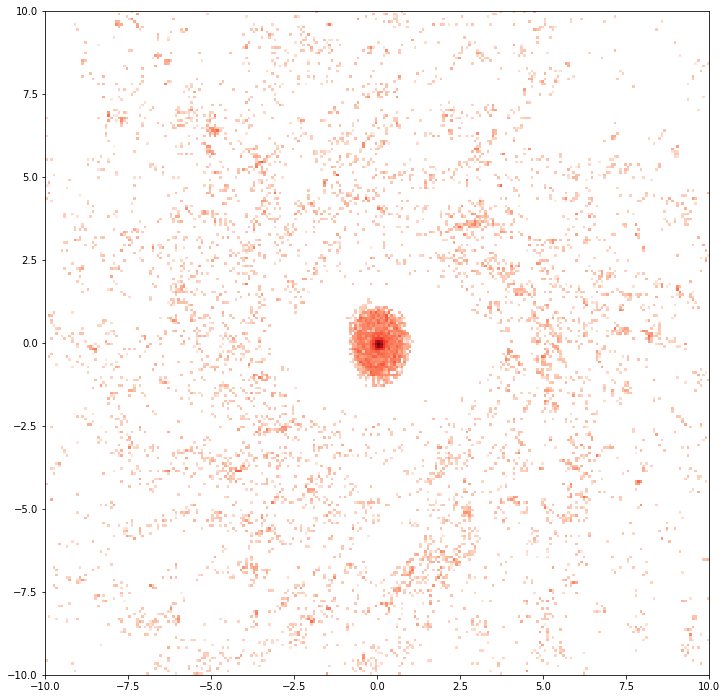

In [12]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

vmin = 0.005
vmax = 0.7

x = pos[:,0]
y = pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=mass)

dx = (range_xy[0][1] - range_xy[0][0])/nres
dy = (range_xy[1][1] - range_xy[1][0])/nres

heatmap_xy /= dx * dy
print(np.max(heatmap_xy))

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))



# ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

heatmap, _, _ = np.histogram2d(young_star_pos[:,0], young_star_pos[:,1], bins=(nres, nres), 
                                range=range_xy, weights=young_star_mass)
heatmap /= dx * dy

print(np.max(heatmap))
print(np.min(heatmap))
# ax.scatter(young_star_pos[:,0], young_star_pos[:,1], c='r', s=0.1)
ax.imshow(heatmap.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds')


ax.set_aspect('equal')
ax.set(xlim=range_xy[0], ylim=range_xy[1])
fig.tight_layout()

plt.show()


4.869330624205771
1.037766858767718
0.0


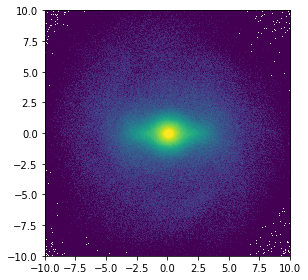

In [10]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]

vmin = 0.005
vmax = 0.7

x = pos[:,0]
y = pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=mass)

dx = (range_xy[0][1] - range_xy[0][0])/nres
dy = (range_xy[1][1] - range_xy[1][0])/nres

heatmap_xy /= dx * dy
print(np.max(heatmap_xy))

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)



ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

heatmap, _, _ = np.histogram2d(young_star_pos[:,0], young_star_pos[:,1], bins=(nres, nres), 
                                range=range_xy, weights=young_star_mass)
heatmap /= dx * dy

print(np.max(heatmap))
print(np.min(heatmap))
# ax.scatter(young_star_pos[:,0], young_star_pos[:,1], c='r', s=0.1)
# ax.imshow(heatmap.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds')


ax.set_aspect('equal')
ax.set(xlim=range_xy[0], ylim=range_xy[1])
fig.tight_layout()

plt.show()
